In [1]:
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import mnist

# MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalization
X_train = X_train.astype(np.float32) #/ 255.
X_test = X_test.astype(np.float32) #/ 255.

# one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

X_train = X_train.astype(int)
X_test = X_test.astype(int)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

2022-11-04 16:00:45.023883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 16:00:45.778014: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-04 16:00:47.213187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-04 16:00:47.213375: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
class Conv3x3:
  def __init__(self, num_filters):
    self.num_filters = num_filters

    # filters is a 3d array with dimensions (num_filters, 3, 3)
    # We divide by 9 to reduce the variance of our initial values
    self.filters = np.random.randn(num_filters, 3, 3) / 9

  def iterate_regions(self, image):
    '''
    Генерируем все возможные 3 на 3 с допущением. что картинка это двумерный массив.
    '''
    h, w = image.shape
    for i in range(h - 2):
      for j in range(w - 2):
        im_region = image[i:(i + 3), j:(j + 3)]
        yield im_region, i, j

  def forward(self, input):
    self.last_input = input

    h, w = input.shape
    output = np.zeros((h - 2, w - 2, self.num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

    return output

  def backprop(self, d_L_d_out, learn_rate):
    '''
    - d_L_d_out - loss gradient
    '''
    d_L_d_filters = np.zeros(self.filters.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      for f in range(self.num_filters):
        d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

    # обновляем фильтры
    self.filters -= learn_rate * d_L_d_filters
    return None

In [3]:
class MaxPool2:
  # pool size 2

  def iterate_regions(self, image):
    '''
    Generates 2x2 image regions to pool over.
    '''
    h, w, _ = image.shape
    new_h = h // 2
    new_w = w // 2

    for i in range(new_h):
      for j in range(new_w):
        im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        yield im_region, i, j

  def forward(self, input):
    self.last_input = input

    h, w, num_filters = input.shape
    output = np.zeros((h // 2, w // 2, num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.amax(im_region, axis=(0, 1))

    return output

  def backprop(self, d_L_d_out):
    d_L_d_input = np.zeros(self.last_input.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      h, w, f = im_region.shape
      amax = np.amax(im_region, axis=(0, 1))

      for i2 in range(h):
        for j2 in range(w):
          for f2 in range(f):
            # если пиксель это максимум копируем градиент
            if im_region[i2, j2, f2] == amax[f2]:
              d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

    return d_L_d_input

In [4]:
class Softmax:
  def __init__(self, input_len, nodes):
    self.weights = np.random.randn(input_len, nodes) / input_len
    self.biases = np.zeros(nodes)

  def forward(self, input):
    self.last_input_shape = input.shape
    input = input.flatten()
    self.last_input = input
    input_len, nodes = self.weights.shape
    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals
    exp = np.exp(totals)
    return exp / np.sum(exp, axis=0)

  def backprop(self, d_L_d_out, learn_rate):
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue
      t_exp = np.exp(self.last_totals)
      S = np.sum(t_exp)
      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)
      d_t_d_w = self.last_input
      d_t_d_b = 1
      d_t_d_inputs = self.weights
      d_L_d_t = gradient * d_out_d_t
      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
      d_L_d_b = d_L_d_t * d_t_d_b
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t
      self.weights -= learn_rate * d_L_d_w
      self.biases -= learn_rate * d_L_d_b

      return d_L_d_inputs.reshape(self.last_input_shape)

In [5]:
train_images = mnist.train_images()[:1000]
train_labels = mnist.train_labels()[:1000]
test_images = mnist.test_images()[:1000]
test_labels = mnist.test_labels()[:1000]

conv = Conv3x3(8)                  # 28x28x1 -> 26x26x8
pool = MaxPool2()                  # 26x26x8 -> 13x13x8
softmax = Softmax(13 * 13 * 8, 10) # 13x13x8 -> 10

def forward(image, label):
  out = conv.forward((image / 255) - 0.5)
  out = pool.forward(out)
  out = softmax.forward(out)

  loss = -np.log(out[label])
  acc = 1 if np.argmax(out) == label else 0

  return out, loss, acc, np.argmax(out)

def train(im, label, lr=.001):
  # Forward
  out, loss, acc, _ = forward(im, label)

  # Calculate initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]

  # Backprop
  gradient = softmax.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc

loss_history = []
# Train
for epoch in range(2):
  print('--- Epoch %d ---' % (epoch + 1))

  # Shuffle the training data
  permutation = np.random.permutation(len(train_images))
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]

  # Train!
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i % 100 == 99:
      print(
        '[Step %d] Average Loss %.3f | Accuracy: %d%%' %
        (i + 1, loss / 100, num_correct)
      )
      loss_history.append(loss/100)
      loss = 0
      num_correct = 0

    l, acc = train(im, label)
    loss += l
    num_correct += acc

--- Epoch 1 ---
[Step 100] Average Loss 2.249 | Accuracy: 20%
[Step 200] Average Loss 2.202 | Accuracy: 22%
[Step 300] Average Loss 2.131 | Accuracy: 28%
[Step 400] Average Loss 2.036 | Accuracy: 50%
[Step 500] Average Loss 1.963 | Accuracy: 52%
[Step 600] Average Loss 1.700 | Accuracy: 65%
[Step 700] Average Loss 1.630 | Accuracy: 64%
[Step 800] Average Loss 1.376 | Accuracy: 71%
[Step 900] Average Loss 1.289 | Accuracy: 71%
[Step 1000] Average Loss 1.079 | Accuracy: 76%
--- Epoch 2 ---
[Step 100] Average Loss 1.056 | Accuracy: 77%
[Step 200] Average Loss 0.869 | Accuracy: 77%
[Step 300] Average Loss 0.743 | Accuracy: 83%
[Step 400] Average Loss 0.813 | Accuracy: 79%
[Step 500] Average Loss 0.778 | Accuracy: 79%
[Step 600] Average Loss 0.549 | Accuracy: 86%
[Step 700] Average Loss 0.680 | Accuracy: 82%
[Step 800] Average Loss 0.586 | Accuracy: 87%
[Step 900] Average Loss 0.625 | Accuracy: 77%
[Step 1000] Average Loss 0.707 | Accuracy: 75%


In [12]:
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
tp = 0
tn = 0
fp = 0
fn = 0
y_pred = []
y_true = []

vectors = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
}
for im, label in zip(test_images, test_labels):
  out, l, acc, a = forward(im, label)
  vectors[a].append(out)
  y_pred.append(a)
  y_true.append(label)
 # print(l, acc, a)
  loss += l
  num_correct += acc
  if label == a:
    if acc == 1:
        tp += 1
    else:
        tn += 1
  else:
    if acc == 1:
        fn += 1
    else:
        fp += 1

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
#recall = tp / (tp + fn)
#f1_score = (2 * precision*recall)/(precision + recall)

##print(f"Test data Accuracy = {accuracy}")
##print(f"Test data Precision = {precision}")
#print(f"Test data Recall = {recall}")
#print(f"Test data F1 score = {f1_score}")

from sklearn.metrics import multilabel_confusion_matrix
r = multilabel_confusion_matrix(y_true, y_pred)
#accuracy = 0
#precision = 0
recall = 0
#f1_score = 0
for cl in r:
    m = np.flip(cl)
    #accuracy += (m[0][0] + m[-1][-1]) / np.sum(m)
    #precision += m[0][0] / (m[0][0] + m[1][0])
    recall += m[0][0] / (m[0][0] + m[0][-1])
    #f1_score = (2 * precision*recall) / (precision+recall)
#accuracy /= len(r)
#precision /= len(r)
recall /= len(r)
f1_score = (2 * precision*recall)/(precision + recall)
#f1_score /= len(r)
    
print("-"*55)
#print(m[0])
print(f"Test data Accuracy = {accuracy}")
print(f"Test data Precision = {precision}")
print(f"Test data Recall = {recall}")
print(f"Test data F1 score = {f1_score}")


num_tests = len(test_images)
print('-'*55)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)


--- Testing the CNN ---
-------------------------------------------------------
Test data Accuracy = 0.792
Test data Precision = 0.792
Test data Recall = 0.7852690146813827
Test data F1 score = 0.7886201451225353
-------------------------------------------------------
Test Loss: 0.6969722406254193
Test Accuracy: 0.792


In [15]:
len(vectors[1][0])

10

In [18]:
#f = open('./vectors.tsv', "w+")
#f_w = open('./v_metadata.tsv', "w+")
#for emb in vectors.keys():
#  for mas in vectors[emb]:
#      f_w.write("{}\n".format(emb))
#      for i in range(len(mas)):
#          f.write("{}\t".format(mas[i]))
#      f.write("\n")
#f.close()
#f_w.close()

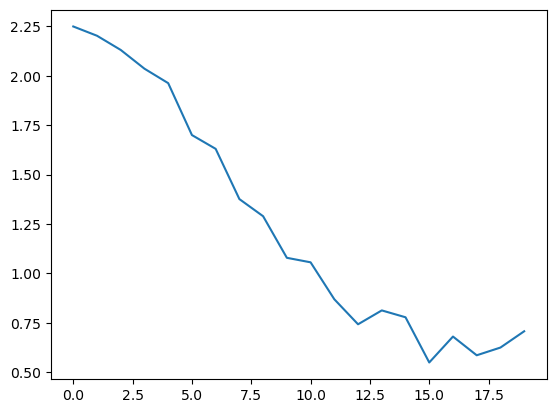

In [7]:
import matplotlib.pyplot as plt
plt.plot(loss_history) 
plt.show()

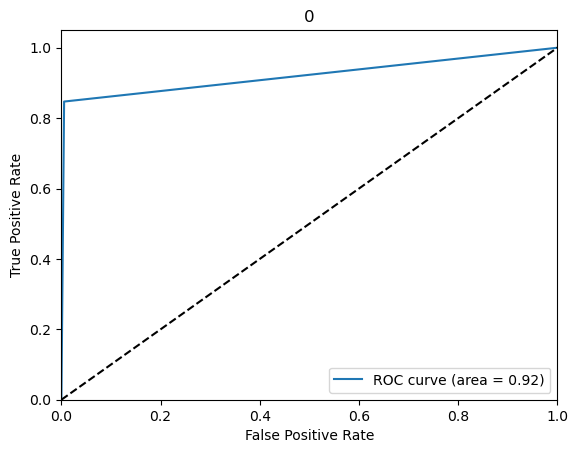

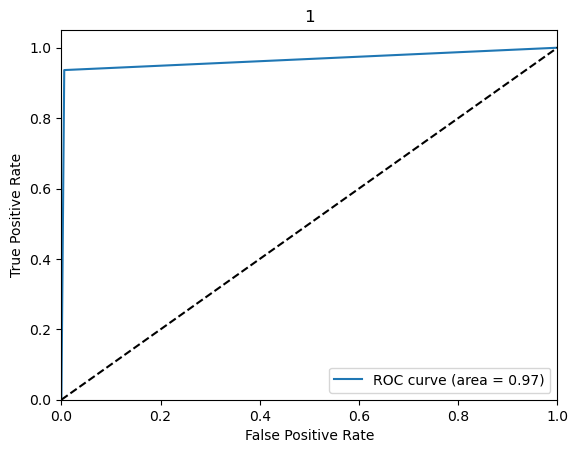

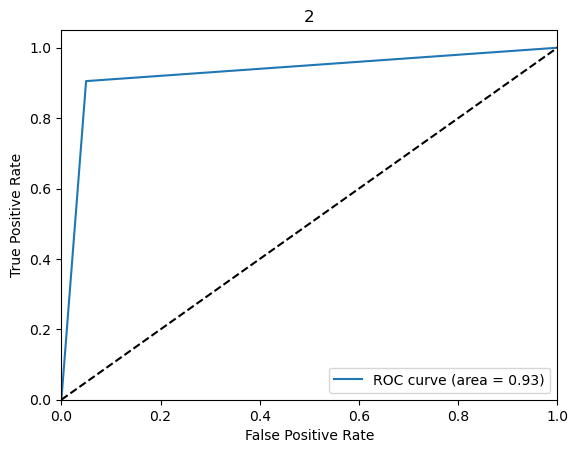

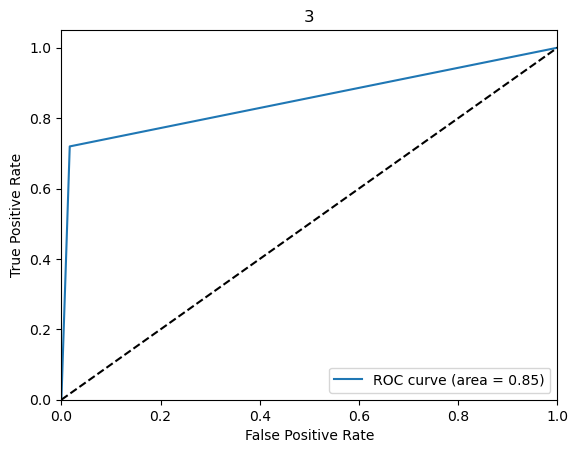

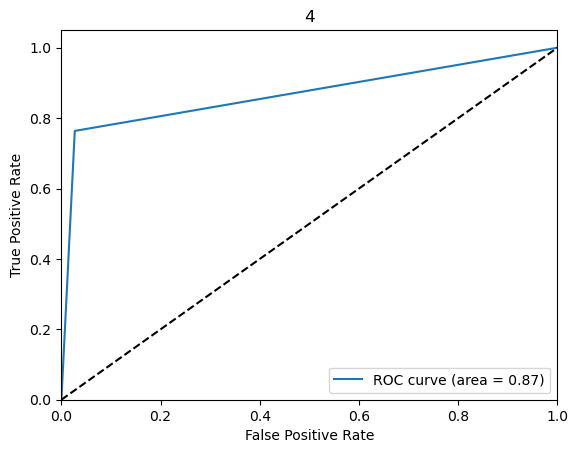

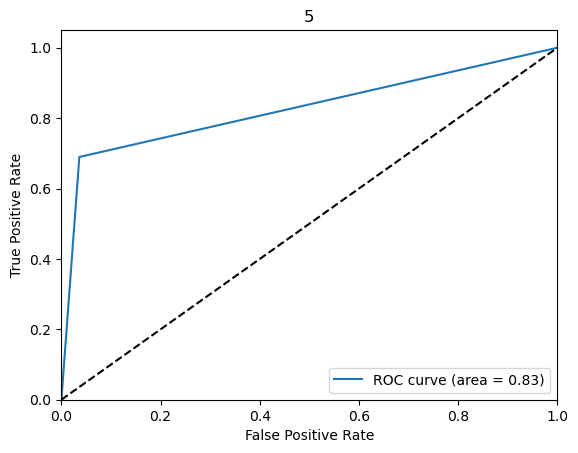

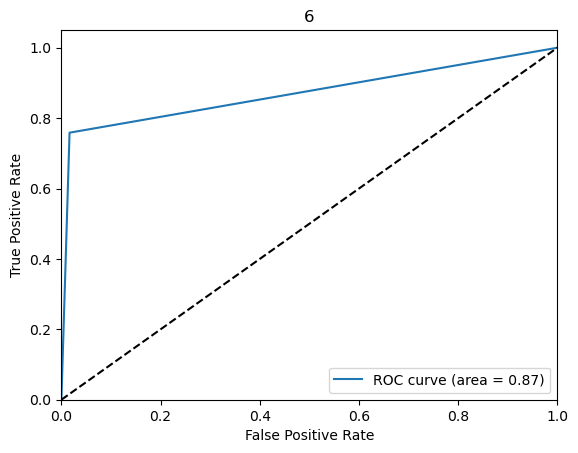

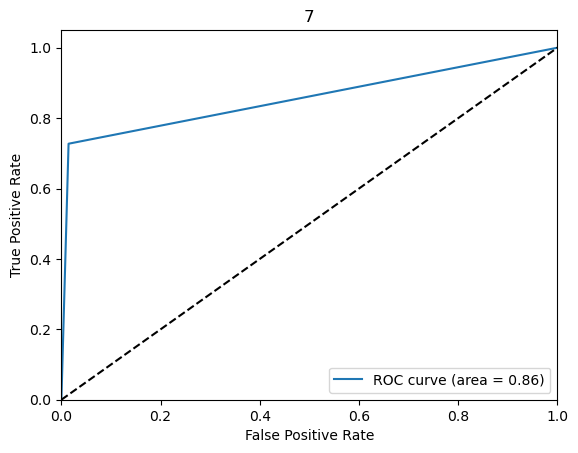

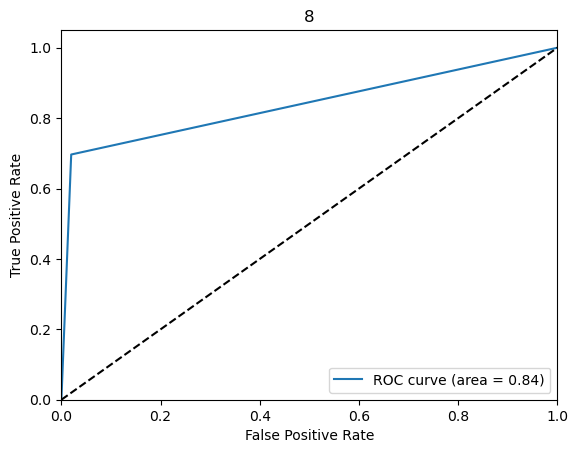

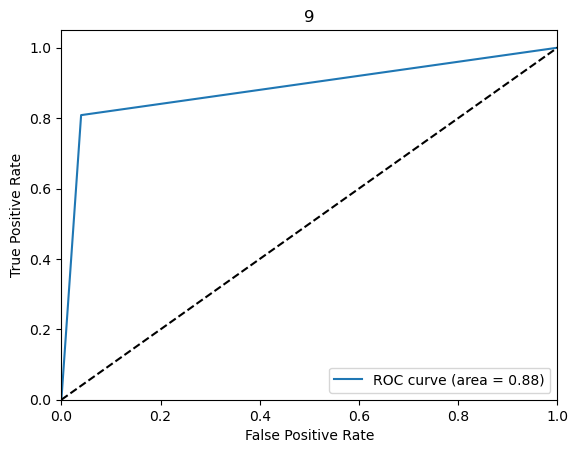

In [8]:
from sklearn import metrics
#fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
#roc_auc = metrics.auc(fpr, tpr)
from sklearn.metrics import roc_curve, auc

roc_mas_pred = dict()
roc_mas_true = {}
for k in range(10):
    f = []
    for i in y_pred:
        if i == k:
            f.append(1)
        else:
            f.append(0)
    roc_mas_pred[k] = f
    
for k in range(10):
    f = []
    for i in y_true:
        if i == k:
            f.append(1)
        else:
            f.append(0)
    roc_mas_true[k] = f
    
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 10
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(roc_mas_true[i], roc_mas_pred[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str(i))
    plt.legend(loc="lower right")
    plt.show()